In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 10})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

# Protocol Pathway A: Control Energy

### Load adjacency

In [2]:
# directory where data is stored
datadir = "/Users/lindenmp/Google-Drive-Rutgers/work/research_projects/nctpy/data"
resultsdir = "/Users/lindenmp/Google-Drive-Rutgers/work/research_projects/nctpy/results"
adjacency_file = "pnc_schaefer200_Am.npy"

In [3]:
# load adjacency matrix
adjacency = np.load(os.path.join(datadir, adjacency_file))
n_nodes = adjacency.shape[0]
print(adjacency.shape)

# check for self-connections
print(np.any(np.diag(adjacency) > 0))

# get density including self connections
density = np.count_nonzero(np.triu(adjacency, k=0)) / (n_nodes**2 / 2)
print(density)

(200, 200)
True
0.9768


### Normalize adjacency

In [4]:
# normalize adjacency matrix
system = "continuous"
adjacency_norm = matrix_normalization(adjacency, system=system, c=1)

### Get initial and target state

In [5]:
# load node-to-system mapping
system_labels = list(
    np.loadtxt(os.path.join(datadir, "pnc_schaefer200_system_labels.txt"), dtype=str)
)

In [6]:
print(len(system_labels))
print(system_labels[:20])

200
['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot']


In [7]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)

In [8]:
print(type(state_labels), len(state_labels), state_labels)

<class 'list'> 7 ['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']


In [9]:
print(type(states), states.shape, states)

<class 'numpy.ndarray'> (200,) [6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
# extract initial state
initial_state = states == state_labels.index("Vis")
# initial_state = states == state_labels.index('Default')

# extract target state
target_state = states == state_labels.index("Default")

# strength of states
strength = np.sum(adjacency, axis=0)
print("initial state strength: {0}".format(np.mean(strength[initial_state])))
print("final state strength: {0}".format(np.mean(strength[target_state])))
bystanders = initial_state + target_state
bystanders = ~bystanders
print("remaining nodes: {0}".format(np.mean(strength[bystanders])))

initial state strength: 67773.32556141318
final state strength: 59454.519733095905
remaining nodes: 53761.60911578159


In [11]:
# normalize state magnitude
initial_state = normalize_state(initial_state)
target_state = normalize_state(target_state)

['Cont' 'Default' 'DorsAttn' 'Limbic' 'SalVentAttn' 'SomMot' 'Vis']


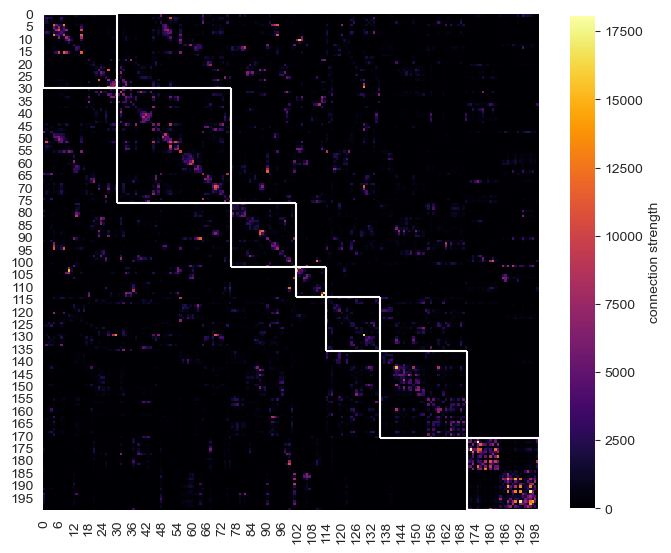

In [12]:
# plot adjacency matrix
sl = pd.Series(system_labels)
sl.sort_values(ascending=True, inplace=True)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    adjacency[sl.index, :][:, sl.index],
    ax=ax,
    square=True,
    cmap="inferno",
    cbar_kws={"label": "connection strength", "shrink": 0.8},
)
add_module_lines(sl, ax)
f.savefig(
    os.path.join(resultsdir, "adjacency.png"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

### Setup control nodes and weights

In [13]:
# helper func for printing descriptive stats
def print_stats(x):
    print(
        "min={:.2f}; max={:.2f}; mean={:.2f}; std={:.2f}; skew={:.2f}; kurt={:.2f}".format(
            np.min(x),
            np.max(x),
            np.mean(x),
            np.std(x),
            sp.stats.skew(x),
            sp.stats.kurtosis(x),
        )
    )

In [14]:
# define a control set
which_control_set = "uniform_full"

if which_control_set == "uniform_full":
    # specify a uniform full control set: all nodes are control nodes
    # and all control nodes are assigned equal control weight
    control_set = np.eye(n_nodes)
elif which_control_set == "uniform_partial":
    # specify a uniform partial control set: some nodes are control nodes
    # and all control nodes are assigned equal control weight
    bystanders = np.logical_and(
        initial_state == 0, target_state == 0
    )  # use initial state and final state to find bystanders. note, this only works for binary states
    control_set = np.zeros((n_nodes, n_nodes))  # initialize control nodes matrix
    control_set[bystanders, bystanders] = 1  # set bystanders to control nodes

    # control nodes: initial state
    # control_set = np.zeros((n_nodes, n_nodes))
    # control_set[initial_state != 0, initial_state != 0] = 1
    # control_set[initial_state == 0, initial_state == 0] = 1e-5  # add a little bit of control to remaining nodes

    # control nodes: final state
    # control_set = np.zeros((n_nodes, n_nodes))
    # control_set[target_state != 0, target_state != 0] = 1
    # control_set[target_state == 0, target_state == 0] = 1e-5  # add a little bit of control to remaining nodes
elif which_control_set == "neuromap":
    neuromap_file = "schaefer200_cyto.npy"
    neuromap = np.load(os.path.join(datadir, neuromap_file))
    print(neuromap.shape)
    print_stats(neuromap)

    # modify neuromap so that its minimum value is 1
    neuromap += 1 + np.abs(np.min(neuromap))
    print_stats(neuromap)

    control_set = np.zeros((n_nodes, n_nodes))  # initialize control nodes matrix
    control_set[np.diag_indices(n_nodes)] = neuromap  # set weights using neuromap

    # plot neuromap on brain surface
    lh_annot_file = (
        "/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/"
        "fsaverage5/lh.Schaefer2018_200Parcels_7Networks_order.annot"
    )
    rh_annot_file = (
        "/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/"
        "fsaverage5/rh.Schaefer2018_200Parcels_7Networks_order.annot"
    )
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")

    f = surface_plot(
        data=neuromap,
        lh_annot_file=lh_annot_file,
        rh_annot_file=rh_annot_file,
        fsaverage=fsaverage,
        order="lr",
        cmap="viridis",
    )
    f.savefig(
        os.path.join(resultsdir, "neuromap.png"),
        dpi=600,
        bbox_inches="tight",
        pad_inches=0.01,
    )

In [15]:
# compare two annotation maps
if which_control_set == "neuromap":
    neuromap_file_1 = "schaefer200_cyto.npy"
    neuromap_1 = np.load(os.path.join(datadir, neuromap_file_1))
    neuromap_1_norm = normalize_weights(neuromap_1)

    neuromap_file_2 = "schaefer200_micro.npy"
    neuromap_2 = np.load(os.path.join(datadir, neuromap_file_2))
    neuromap_2_norm = normalize_weights(neuromap_2)

    print_stats(neuromap)
    print_stats(neuromap_1_norm)
    print_stats(neuromap_2)
    print_stats(neuromap_2_norm)

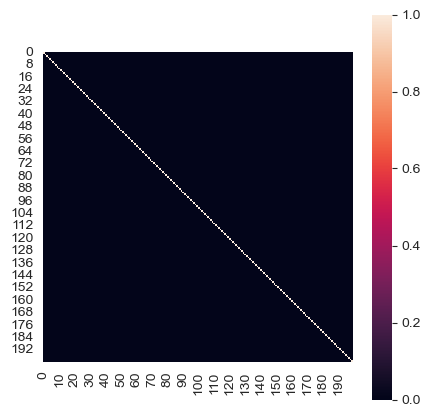

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(control_set, ax=ax, square=True)
plt.show()
print(control_set.diagonal())

In [17]:
# set parameters
time_horizon = 1  # time horizon (T)
rho = 1  # mixing parameter for state trajectory constraint
trajectory_constraints = np.eye(n_nodes)  # nodes in state trajectory to be constrained

# get the state trajectory and the control signals
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=adjacency_norm,
    T=time_horizon,
    B=control_set,
    x0=initial_state,
    xf=target_state,
    system=system,
    rho=rho,
    S=trajectory_constraints,
)

# print errors
thr = 1e-8

# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
        numerical_error[0], thr, numerical_error[0] < thr
    )
)

# the second numerical error corresponds to the reconstruction error
print(
    "reconstruction error = {:.2E} (<{:.2E}={:})".format(
        numerical_error[1], thr, numerical_error[1] < thr
    )
)

inversion error = 1.38E-15 (<1.00E-08=True)
reconstruction error = 1.42E-13 (<1.00E-08=True)


### Plot state_trajectory and control_signals

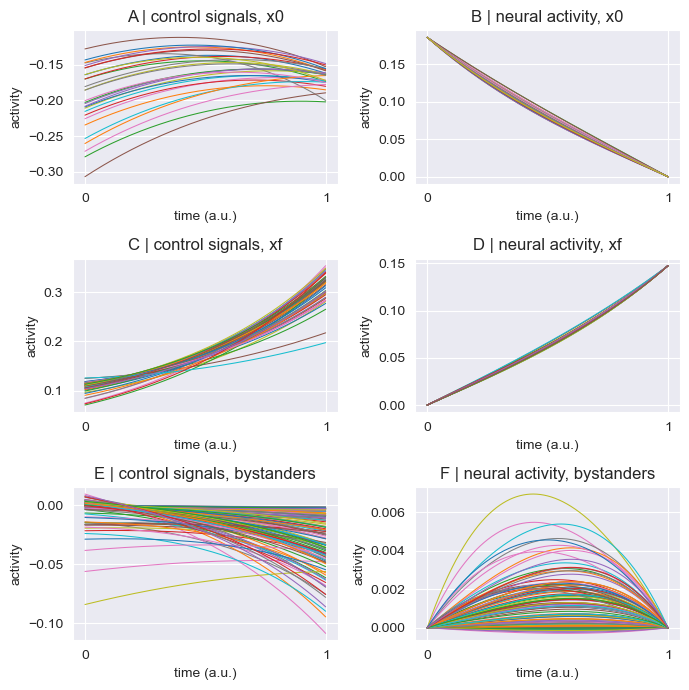

In [18]:
f, ax = plt.subplots(3, 2, figsize=(7, 7))
# plot control signals for initial state
ax[0, 0].plot(control_signals[:, initial_state != 0], linewidth=0.75)
ax[0, 0].set_title("A | control signals, x0")
# plot state trajectory for initial state
ax[0, 1].plot(state_trajectory[:, initial_state != 0], linewidth=0.75)
ax[0, 1].set_title("B | neural activity, x0")

# plot control signals for target state
ax[1, 0].plot(control_signals[:, target_state != 0], linewidth=0.75)
ax[1, 0].set_title("C | control signals, xf")
# plot state trajectory for target state
ax[1, 1].plot(state_trajectory[:, target_state != 0], linewidth=0.75)
ax[1, 1].set_title("D | neural activity, xf")

# plot control signals for bystanders
ax[2, 0].plot(
    control_signals[:, np.logical_and(initial_state == 0, target_state == 0)],
    linewidth=0.75,
)
ax[2, 0].set_title("E | control signals, bystanders")
# plot state trajectory for bystanders
ax[2, 1].plot(
    state_trajectory[:, np.logical_and(initial_state == 0, target_state == 0)],
    linewidth=0.75,
)
ax[2, 1].set_title("F | neural activity, bystanders")

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (a.u.)")
    cax.set_xticks([0, state_trajectory.shape[0]])
    cax.set_xticklabels([0, time_horizon])

f.tight_layout()
f.savefig(
    os.path.join(resultsdir, "plot_xu.svg"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

### Compute control energy

In [19]:
# integrate control signals to get control energy
node_energy = integrate_u(control_signals)
print(node_energy.shape)
print(np.round(node_energy[:5], 2))

# summarize nodal energy
energy = np.sum(node_energy)
if energy > 1e4:
    print("energy = {:.2E}".format(np.round(energy, 2)))
else:
    print("energy = {:.2F}".format(np.round(energy, 2)))

(200,)
[21.13 37.65 23.55 21.55 28.34]
energy = 2604.71


## Variant: data-driven optimization of control weights

In [20]:
if which_control_set == "uniform_full":
    # container for perturbed energies
    energy_perturbed = np.zeros(n_nodes)

    for node in tqdm(np.arange(n_nodes)):
        # start with a uniform full control set
        control_set = np.eye(n_nodes)

        # add arbitrary amount of additional control to node
        control_set[node, node] += 0.1

        # get perturbed control signals (u_p)
        _, control_signals, _ = get_control_inputs(
            A_norm=adjacency_norm,
            T=time_horizon,
            B=control_set,
            x0=initial_state,
            xf=target_state,
            system=system,
            rho=rho,
            S=trajectory_constraints,
        )

        # integrate control signals to get control energy
        node_energy = integrate_u(control_signals)

        # summarize nodal energy
        energy_perturbed[node] = np.sum(node_energy)

    # check if perturbed energy is lower than original energy. Should print True
    print(np.all(energy_perturbed < energy))

    # calculate energy delta. these values will all be negative,
    # indicating reduced energy compared to control_set=np.eye(n_nodes)
    energy_delta = energy_perturbed - energy

100%|██████████| 200/200 [00:20<00:00,  9.72it/s]

True


In [21]:
if which_control_set == "uniform_full":
    # re-compute energy using energy deltas as weights
    # we do this by taking a single step down the
    # gradient created by the energy deltas
    learning_rate = 0.01  # set a learning rate for gradient descent
    control_set = np.zeros(
        (n_nodes, n_nodes)
    )  # initialize container for optimized weights
    control_set[np.diag_indices(n_nodes)] = (
        1 - energy_delta * learning_rate
    )  # step down gradient
    control_set = (
        control_set / sp.linalg.norm(control_set) * sp.linalg.norm(control_set)
    )  # normalize
    # normalization ensures that the optimized weights have the same
    # norm as control_set=np.eye(n_nodes)

    # get optimized control signals
    _, control_signals, _ = get_control_inputs(
        A_norm=adjacency_norm,
        T=time_horizon,
        B=control_set,
        x0=initial_state,
        xf=target_state,
        system=system,
        rho=rho,
        S=trajectory_constraints,
    )

    # integrate control signals to get control energy
    node_energy_optimized = integrate_u(control_signals)

    print(np.round(node_energy_optimized[:5], 2))

    # summarize nodal energy
    energy_optimized = np.sum(node_energy_optimized)

    print(np.round(energy_optimized, 2))

[19.7  33.45 21.81 20.05 25.83]
2326.71


In [22]:
if which_control_set == "uniform_full":
    control_task = dict()  # initialize dict
    control_task["x0"] = initial_state  # store initial state
    control_task["xf"] = target_state  # store target state
    control_task["S"] = trajectory_constraints  # store state trajectory constraints
    control_task["rho"] = rho  # store rho
    compute_opt_control_energy = ComputeOptimizedControlEnergy(
        A=adjacency,
        control_task=control_task,
        system=system,
        c=1,
        T=time_horizon,
        n_steps=2,
        lr=learning_rate,
    )
    compute_opt_control_energy.run()

    print(compute_opt_control_energy.E_opt.shape)
    print(compute_opt_control_energy.B_opt.shape)

Running gradient step 0


100%|██████████| 200/200 [00:23<00:00,  8.47it/s]


Running gradient step 1


100%|██████████| 200/200 [00:23<00:00,  8.66it/s]


(2,)
(2, 200)


## Effect of edge density

[0.9518 0.9268 0.9018 0.8768 0.8518 0.8268 0.8018 0.7768 0.7518 0.7268
 0.7018 0.6768 0.6518 0.6268 0.6018 0.5768 0.5518 0.5268 0.5018 0.4768
 0.4518 0.4268 0.4018 0.3768 0.3518 0.3268 0.3018 0.2768 0.2518 0.2268
 0.2018 0.1768 0.1518 0.1268 0.1018 0.0768]
[2326.7196786  2326.74344061 2326.77903449 2326.82943334 2326.87815819
 2326.95085006 2327.02493087 2327.09576541 2327.16768046 2327.26987786
 2327.42843928 2327.63240264 2327.85696128 2328.07622988 2328.35784762
 2328.59915332 2328.95502103 2329.29512025 2329.74306332 2330.1752133
 2330.56848007 2331.01262285 2331.52325866 2332.09954693 2332.59486473
 2333.19613667 2334.36935706 2335.42301199 2335.88982046 2337.44961071
 2338.45751845 2339.98974533 2340.69151287 2341.66074657 2350.77925426
 2357.02897567]


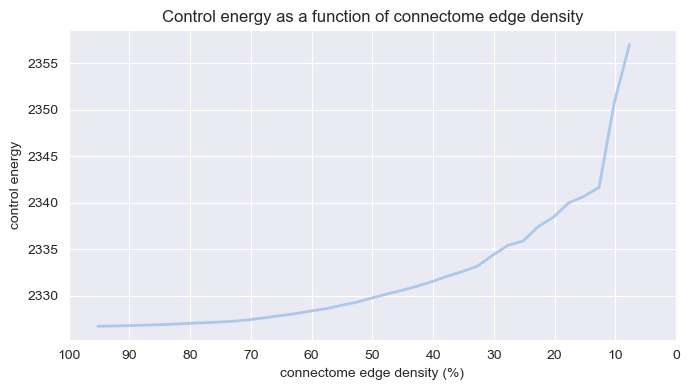

In [23]:
run = True
if run:
    # for reproducibility
    np.random.seed(0)

    adjacency_pruned = adjacency.copy()
    n_delete = 500

    density_pruned_list = []
    E_prune = []

    density_pruned = density
    while density_pruned > 0.1:
        for j in np.arange(n_delete):
            # find non-zero edges
            idx = np.where(adjacency_pruned > 0)

            # # randomly sample one non-zero edge
            # id = np.random.randint(0, len(idx[0]), 1)
            # # set edge to 0
            # adjacency_pruned[idx[0][id], idx[1][id]] = 0
            # adjacency_pruned[idx[1][id], idx[0][id]] = 0

            # sample lowest edge weight
            id_min = np.argmin(adjacency_pruned[idx])
            id_min_loc = np.where(adjacency_pruned == adjacency_pruned[idx][id_min])
            # set edge to 0
            if len(id_min_loc[0]) == 1:
                adjacency_pruned[id_min_loc[0][0], id_min_loc[0][0]] = 0
            elif len(id_min_loc[0]) == 2:
                adjacency_pruned[id_min_loc[0][0], id_min_loc[0][1]] = 0
                adjacency_pruned[id_min_loc[1][0], id_min_loc[1][1]] = 0

            # # sample largest edge weight
            # id_max = np.argmax(adjacency_pruned[idx])
            # id_max_loc = np.where(adjacency_pruned == adjacency_pruned[idx][id_max])
            # # set edge to 0
            # if len(id_max_loc[0]) == 1:
            #     adjacency_pruned[id_max_loc[0][0], id_max_loc[0][0]] = 0
            # elif len(id_max_loc[0]) == 2:
            #     adjacency_pruned[id_max_loc[0][0], id_max_loc[0][1]] = 0
            #     adjacency_pruned[id_max_loc[1][0], id_max_loc[1][1]] = 0

        # normalize pruned adjacency
        adjacency_pruned_norm = matrix_normalization(
            adjacency_pruned, system=system, c=1
        )
        # get control signals
        _, u_pruned, _ = get_control_inputs(
            A_norm=adjacency_pruned_norm,
            T=time_horizon,
            B=control_set,
            x0=initial_state,
            xf=target_state,
            system=system,
            rho=rho,
            S=trajectory_constraints,
        )
        # integrate control signals to get control energy
        node_energy = integrate_u(u_pruned)
        # summarize nodal energy
        E_prune.append(np.sum(node_energy))

        density_pruned = np.count_nonzero(np.triu(adjacency_pruned, k=0)) / (
            n_nodes**2 / 2
        )
        density_pruned_list.append(density_pruned)

    density_pruned = np.asarray(density_pruned_list)
    E_prune = np.asarray(E_prune)

    print(density_pruned)
    print(E_prune)

    # plot
    f, ax = plt.subplots(figsize=(7, 4))
    blue = [171 / 255, 201 / 255, 234 / 255]
    # plot control signals for initial state
    ax.plot(density_pruned * 100, E_prune, linewidth=2, color=blue)
    ax.set_title("Control energy as a function of connectome edge density")
    ax.set_ylabel("control energy")
    ax.set_xlabel("connectome edge density (%)")
    ax.set_xticks(np.arange(0, 110, 10))
    ax.invert_xaxis()

    f.tight_layout()
    f.savefig(
        os.path.join(resultsdir, "energy_density.svg"),
        dpi=600,
        bbox_inches="tight",
        pad_inches=0.01,
    )
    plt.show()

## Null network models

In [24]:
# null networks
centroids = pd.read_csv(
    os.path.join(datadir, "pnc_schaefer200_centroids.csv")
)  # load coordinates of nodes
centroids.set_index("node_names", inplace=True)
print(centroids.head())

distance_matrix = distance.pdist(
    centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

            vox_x  vox_y  vox_z
node_names                     
LH_Vis_1      121    149     69
LH_Vis_2      123    174     65
LH_Vis_3      143    166     70
LH_Vis_4      107    164     74
LH_Vis_5      124    192     66


In [25]:
# to paste into manuscript
run = False
if run:
    # extract initial state
    initial_state = states == state_labels.index("Vis")  # 'Vis' or 'SalVentAttn'
    initial_state = normalize_state(initial_state)  # normalize

    # extract target state
    target_state = states == state_labels.index("Default")
    target_state = normalize_state(target_state)  # normalize

    # compute true control energy
    _, control_signals, _ = get_control_inputs(
        A_norm=adjacency_norm,
        T=time_horizon,
        B=control_set,
        x0=initial_state,
        xf=target_state,
        system=system,
        rho=rho,
        S=trajectory_constraints,
    )
    node_energy = integrate_u(control_signals)  # integrate control signals
    energy = np.sum(node_energy)  # get energy

    # run permutation
    n_perms = 5000  # number of permutations

    # containers for null distributions
    energy_null_sp = np.zeros(n_perms)
    energy_null_ssp = np.zeros(n_perms)

    for perm in tqdm(np.arange(n_perms)):
        # rewire adjacency matrix using geomsurr
        _, Wsp, Wssp = geomsurr(W=adjacency, D=distance_matrix, seed=perm)
        # Wsp is the adjacency matrix rewired while preserving spatial embedding and the strength distribution
        # Wssp is the adjacency matrix rewired while preserving spatial embedding and the strength sequence
        # this python implementation is included with our toolbox, but if you use these nulls
        # in your own work, please cite:
        #       Roberts et al. NeuroImage (2016), doi:10.1016/j.neuroimage.2015.09.009

        # compute control energy for Wsp
        Wsp = matrix_normalization(Wsp, system=system)
        _, control_signals, _ = get_control_inputs(
            A_norm=Wsp,
            T=time_horizon,
            B=control_set,
            x0=initial_state,
            xf=target_state,
            system=system,
            rho=rho,
            S=trajectory_constraints,
        )
        node_energy = integrate_u(control_signals)
        energy_null_sp[perm] = np.sum(node_energy)

        # compute control energy for Wssp
        Wssp = matrix_normalization(Wssp, system=system)
        _, control_signals, _ = get_control_inputs(
            A_norm=Wssp,
            T=time_horizon,
            B=control_set,
            x0=initial_state,
            xf=target_state,
            system=system,
            rho=rho,
            S=trajectory_constraints,
        )
        node_energy = integrate_u(control_signals)
        energy_null_ssp[perm] = np.sum(node_energy)

    # plot
    f, ax = plt.subplots(1, 2, figsize=(7, 3))
    null_plot(
        observed=energy,
        null=energy_null_sp,
        xlabel="strength-preserving",
        ax=ax[0],
    )
    null_plot(
        observed=energy,
        null=energy_null_ssp,
        xlabel="sequence-preserving",
        ax=ax[1],
    )
    f.tight_layout()
    f.savefig(
        os.path.join(resultsdir, "energy_network_null.svg"),
        dpi=600,
        bbox_inches="tight",
        pad_inches=0.01,
    )
    plt.show()

In [26]:
# for figures
run = False
if run:
    n_perms = 5000

    transitions = [
        ["Vis", "Default"],
        ["Default", "Vis"],
        ["SalVentAttn", "Default"],
        ["Default", "SalVentAttn"],
    ]
    for transition in transitions:
        # extract initial state
        state_i = transition[0]
        initial_state = states == state_labels.index(state_i)
        initial_state = normalize_state(initial_state)

        # extract target state
        state_j = transition[1]
        target_state = states == state_labels.index(state_j)
        target_state = normalize_state(target_state)

        print(state_i, state_j)

        energy_null_sp = np.zeros(n_perms)
        energy_null_ssp = np.zeros(n_perms)

        for perm in tqdm(np.arange(n_perms)):
            _, Wsp, Wssp = geomsurr(W=adjacency, D=distance_matrix, seed=perm)

            Wsp = matrix_normalization(
                Wsp, system=system
            )  # normalize rewired adjacency matrix
            _, control_signals, _ = get_control_inputs(
                A_norm=Wsp,
                T=time_horizon,
                B=control_set,
                x0=initial_state,
                xf=target_state,
                system=system,
                rho=rho,
                S=trajectory_constraints,
            )
            node_energy = integrate_u(control_signals)  # integrate null control signals
            energy_null_sp[perm] = np.sum(node_energy)  # store null energy

            Wssp = matrix_normalization(
                Wssp, system=system
            )  # normalize rewired adjacency matrix
            _, control_signals, _ = get_control_inputs(
                A_norm=Wssp,
                T=time_horizon,
                B=control_set,
                x0=initial_state,
                xf=target_state,
                system=system,
                rho=rho,
                S=trajectory_constraints,
            )
            node_energy = integrate_u(control_signals)  # integrate null control signals
            energy_null_ssp[perm] = np.sum(node_energy)  # store null energy

        np.save(
            os.path.join(resultsdir, "energy_null_sp_{0}_{1}".format(state_i, state_j)),
            energy_null_sp,
        )
        np.save(
            os.path.join(
                resultsdir, "energy_null_ssp_{0}_{1}".format(state_i, state_j)
            ),
            energy_null_ssp,
        )
else:
    pass

In [27]:
run = False
if run:
    f, ax = plt.subplots(1, 4, figsize=(7, 2))

    # i-->j
    state_i = "Vis"  # 'Vis' or 'SalVentAttn'
    initial_state = states == state_labels.index(state_i)
    initial_state = normalize_state(initial_state)
    state_j = "Default"
    target_state = states == state_labels.index(state_j)
    target_state = normalize_state(target_state)

    _, control_signals, _ = get_control_inputs(
        A_norm=adjacency_norm,
        T=time_horizon,
        B=control_set,
        x0=initial_state,
        xf=target_state,
        system=system,
        rho=rho,
        S=trajectory_constraints,
    )
    node_energy = integrate_u(control_signals)
    energy = np.sum(node_energy)

    energy_null_sp = np.load(
        os.path.join(resultsdir, "energy_null_sp_{0}_{1}.npy".format(state_i, state_j))
    )
    energy_null_ssp = np.load(
        os.path.join(resultsdir, "energy_null_ssp_{0}_{1}.npy".format(state_i, state_j))
    )

    p_val = get_null_p(energy, energy_null_sp, version="reverse", abs=False)
    null_plot(
        observed=energy,
        null=energy_null_sp,
        p_val=p_val,
        xlabel="strength-preserving",
        ax=ax[0],
    )
    ax[0].set_title("A | {0} to {1}".format(state_i, state_j))

    p_val = get_null_p(energy, energy_null_ssp, version="reverse", abs=False)
    null_plot(
        observed=energy,
        null=energy_null_ssp,
        p_val=p_val,
        xlabel="sequence-preserving",
        ax=ax[1],
    )

    # j-->i
    state_i = "Default"
    initial_state = states == state_labels.index(state_i)
    initial_state = normalize_state(initial_state)
    state_j = "Vis"  # 'Vis' or 'SalVentAttn'
    target_state = states == state_labels.index(state_j)
    target_state = normalize_state(target_state)

    _, control_signals, _ = get_control_inputs(
        A_norm=adjacency_norm,
        T=time_horizon,
        B=control_set,
        x0=initial_state,
        xf=target_state,
        system=system,
        rho=rho,
        S=trajectory_constraints,
    )
    node_energy = integrate_u(control_signals)
    energy = np.sum(node_energy)

    energy_null_sp = np.load(
        os.path.join(resultsdir, "energy_null_sp_{0}_{1}.npy".format(state_i, state_j))
    )
    energy_null_ssp = np.load(
        os.path.join(resultsdir, "energy_null_ssp_{0}_{1}.npy".format(state_i, state_j))
    )

    p_val = get_null_p(energy, energy_null_sp, version="reverse", abs=False)
    null_plot(
        observed=energy,
        null=energy_null_sp,
        p_val=p_val,
        xlabel="strength-preserving",
        ax=ax[2],
    )
    ax[2].set_title("B | {0} to {1}".format(state_i, state_j))

    p_val = get_null_p(energy, energy_null_ssp, version="reverse", abs=False)
    null_plot(
        observed=energy,
        null=energy_null_ssp,
        p_val=p_val,
        xlabel="sequence-preserving",
        ax=ax[3],
    )

    f.tight_layout()
    f.savefig(
        os.path.join(resultsdir, "energy_network_null.svg"),
        dpi=600,
        bbox_inches="tight",
        pad_inches=0.01,
    )
    plt.show()